In [0]:
#!/usr/bin/env python
# coding: utf-8

# This script generates the MINICIFAR dataset from CIFAR10
# The following parameters can be changed : 
# n_classes (between 2 and 10) 
# Reduction factor R (which will result in 10000 /  R examples per class for the train set, and 1000 / R per class for test)
# --


n_classes_minicifar = 4
R = 5


# Download the entire CIFAR10 dataset

from torchvision.datasets import CIFAR10
import numpy as np 
from torch.utils.data import Subset

import torchvision.transforms as transforms

## Normalization is different when training from scratch and when training using an imagenet pretrained backbone

normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

normalize_forimagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Data augmentation is needed in order to train from scratch
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

## No data augmentation when using Transfer Learning
transform_train_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])

transform_test_imagenet = transforms.Compose([
    transforms.ToTensor(),
    normalize_forimagenet,
])


### The data from CIFAR10 will be downloaded in the following dataset
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

c10train_imagenet = CIFAR10(rootdir,train=True,download=True,transform=transform_train_imagenet)
c10test_imagenet = CIFAR10(rootdir,train=False,download=True,transform=transform_test_imagenet)

# Generating Mini-CIFAR
# 
# CIFAR10 is sufficiently large so that training a model up to the state of the art performance will take approximately 3 hours on the 1060 GPU available on your machine. 
# As a result, we will create a "MiniCifar" dataset, based on CIFAR10, with less classes and exemples. 

def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):

    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 

    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)


    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    
    return Subset(dataset,indices=all_indices)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, size_factor=64):
        super(ResNet, self).__init__()
        self.in_planes = size_factor

        self.conv1 = nn.Conv2d(3, size_factor, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(size_factor)
        self.layer1 = self._make_layer(block, size_factor, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*size_factor, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*size_factor, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*size_factor, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*size_factor*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

def ResNetCustom(size_factor, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], size_factor=size_factor, num_classes=num_classes)


In [0]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import json

def main(batch_size, epoch, size_factor, step_size, gamma, initial_rate):
    
    ### These dataloader are ready to be used to train for scratch 
    minicifar_train = generate_subset(dataset=c10train,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=5000)
    trainloader = DataLoader(minicifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    minicifar_test = generate_subset(dataset=c10test,n_classes=n_classes_minicifar,reducefactor=5,n_ex_class_init=1000)
    testloader = DataLoader(minicifar_test,batch_size=batch_size, num_workers=2)
    

    ##Training
    net = ResNetCustom(size_factor=size_factor, num_classes=4)
    net = net.cuda()
    

    loss_history_train, loss_history_test = [], []
    accu_history_train, accu_history_test = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=initial_rate, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


    ###### RUNNING TRAIN #########
    for i in range(epoch):
        correct = 0.0
        correct_test = 0.0
        running_loss = 0.0
        running_loss_test = 0.0
        total = 0.0
        total_test = 0.0
        
        net.train()
        for _, (data, labels) in enumerate(trainloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()

            # zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            # compute statistics
            total += labels.size(0)
            running_loss += loss.item()
            predicted = outputs.max(1)[1]
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
        accu_history_train.append(100*correct/total)
        loss_history_train.append(running_loss)

        #print('loss: %.3f' %(running_loss))
        #print('accuracy: %.3f' %(100*correct/total))
        
        net.eval()
        
        for _, (data, labels) in enumerate(testloader):
            #setting to cuda
            data = data.cuda()
            labels = labels.cuda()
            
            # compute
            outputs = net(data)
            loss = criterion(outputs, labels)

            # compute statistics
            total_test += labels.size(0)
            running_loss_test += loss.item()
            predicted = outputs.max(1)[1]
            correct_test += predicted.eq(labels).sum().item()

        accu_history_test.append(100*correct_test/total_test)
        loss_history_test.append(running_loss_test)

    
    
    ###### RUNNING TEST #######
    
        
    print('Finished Training/Testing')
    
    state_dict = {}
    
    state_dict.update({"size_factor": size_factor, "batch_size": batch_size, "epoch": epoch, "accu_test": accu_history_test, "accu_train": accu_history_train, "loss_test": loss_history_test, "loss_train": loss_history_train, "step_size":step_size, "gamma":gamma, "initial_rate":initial_rate})
    
    with open('bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + 'sz' + str(step_size) + 'ga' + str(gamma) + 'ir' + str(initial_rate) + '.json', 'w') as file:
        file.write(json.dumps(state_dict))
        
    torch.save(net.state_dict, 'bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + 'sz' + str(step_size) + 'ga' + str(gamma) + 'ir' + str(initial_rate) + '.pth')

In [0]:
main(batch_size=32, size_factor=16, epoch=30, step_size=5, gamma=0.1, initial_rate = 0.1)

loss: 179.402
accuracy: 38.650
loss: 143.589
accuracy: 49.925
loss: 122.529
accuracy: 58.050
loss: 114.253
accuracy: 61.775
loss: 103.882
accuracy: 65.575
loss: 91.129
accuracy: 70.050
loss: 88.516
accuracy: 71.250
loss: 86.600
accuracy: 71.275
loss: 85.824
accuracy: 71.875
loss: 84.374
accuracy: 72.925
loss: 81.272
accuracy: 73.900
loss: 81.376
accuracy: 73.050
loss: 82.411
accuracy: 72.800
loss: 82.637
accuracy: 73.125
loss: 80.837
accuracy: 73.925
loss: 81.031
accuracy: 74.150
loss: 81.816
accuracy: 73.825
loss: 80.378
accuracy: 74.075
loss: 79.461
accuracy: 74.450
loss: 80.916
accuracy: 73.275
loss: 80.180
accuracy: 73.850
loss: 80.004
accuracy: 73.875
loss: 81.273
accuracy: 73.050
loss: 79.551
accuracy: 74.050
loss: 79.801
accuracy: 74.700
loss: 81.399
accuracy: 74.075
loss: 81.143
accuracy: 73.800
loss: 79.877
accuracy: 73.775
loss: 81.181
accuracy: 73.750
loss: 79.576
accuracy: 74.575
Finished Training/Testing


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
import matplotlib.pyplot as plt
import json

def plot(batch_size, epoch, size_factor, step_size, gamma, initial_rate):
    
    with open('bs' + str(batch_size) + 'ep' + str(epoch) + 'sf' + str(size_factor) + 'sz' + str(step_size) + 'ga' + str(gamma) + 'ir' + str(initial_rate) + '.json', 'r') as file:
        text = file.read()
        jf = json.loads(text)
        accu_train = jf["accu_train"]
        accu_test = jf["accu_test"]
        loss_test = jf["loss_test"]
        loss_train = jf["loss_train"]
        
    fig, ax = plt.subplots()
    ax.plot(loss_train, '-b', label = "Loss train")
    ax.plot(loss_test, '-r', label = "Loss test")
    #Config 1
    #Size_factor = 8
    #Epoch = 150
    #Batch_size = 32
    plt.title("Loss" )
    plt.text(0.5, 0.7, ' bs ' + str(batch_size) + ' ep ' + str(epoch) + ' sf ' + str(size_factor) + ' sz ' + str(step_size) + ' ga ' + str(gamma) + ' ir ' + str(initial_rate), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax.legend()
    plt.savefig('loss_' + ' bs ' + str(batch_size) + ' ep ' + str(epoch) + ' sf ' + str(size_factor) + ' sz ' + str(step_size) + ' ga ' + str(gamma) + ' ir ' + str(initial_rate) + '.pdf')
    
    fig_1, ax_1 = plt.subplots()
    ax_1.plot(accu_train, '-b', label = "Accuracy train")
    ax_1.plot(accu_test, '-r', label = "Accuracy test")
    plt.title("Accuracy")
    plt.text(0.5, 0.4, ' bs ' + str(batch_size) + ' ep ' + str(epoch) + ' sf ' + str(size_factor) + ' sz ' + str(step_size) + ' ga ' + str(gamma) + ' ir ' + str(initial_rate), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    ax_1.legend()
    plt.savefig('accu_' + ' bs ' + str(batch_size) + ' ep ' + str(epoch) + ' sf ' + str(size_factor) + ' sz ' + str(step_size) + ' ga ' + str(gamma) + ' ir ' + str(initial_rate) + '.pdf')

    plt.show()



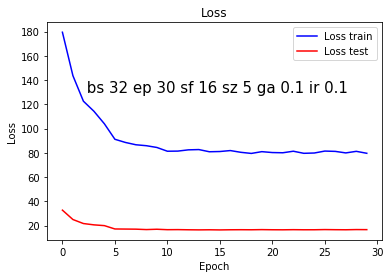

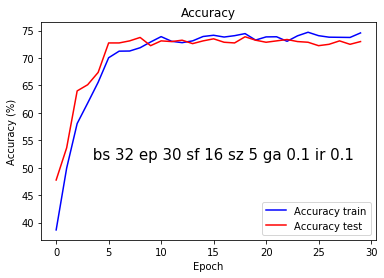

In [0]:
plot(batch_size=32, epoch = 30, size_factor = 16, step_size = 5, gamma = 0.1, initial_rate = 0.1)

Finished Training/Testing
 initial_rate :1 step_size : 5 gamma :0.1 | done !


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Finished Training/Testing
 initial_rate :1 step_size : 5 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :1 step_size : 10 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :1 step_size : 10 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :1 step_size : 15 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :1 step_size : 15 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 5 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 5 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 10 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 10 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 15 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :0.1 step_size : 15 gamma :0.001 | done !
Finished Training/Testing
 initial_rate :0.01 step_size : 5 gamma :0.1 | done !
Finished Training/Testing
 initial_rate :

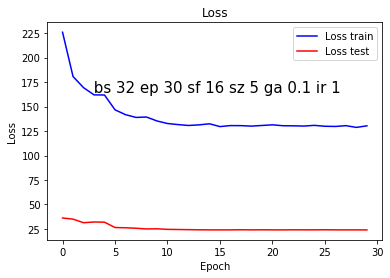

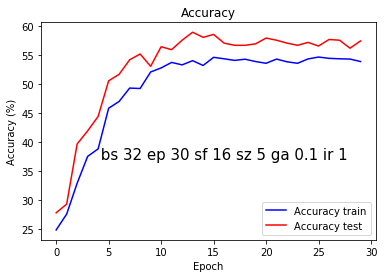

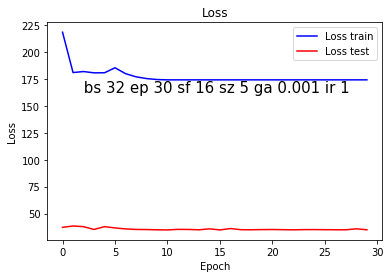

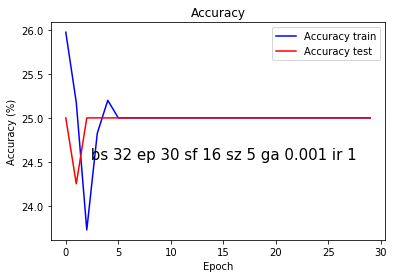

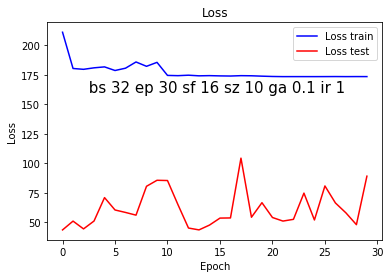

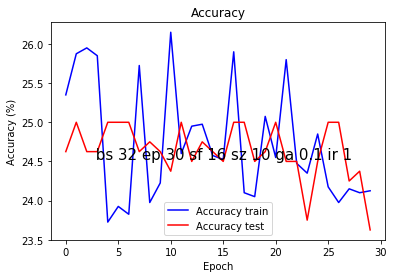

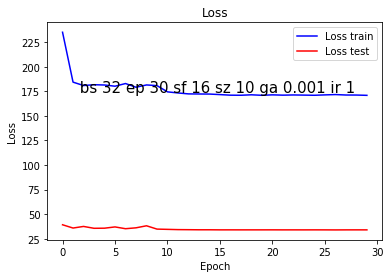

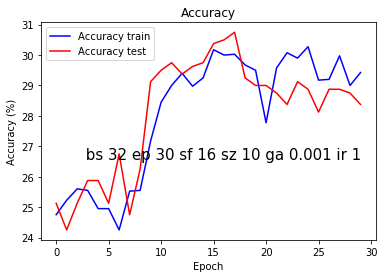

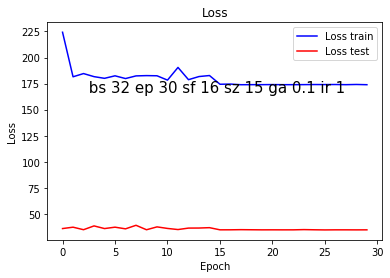

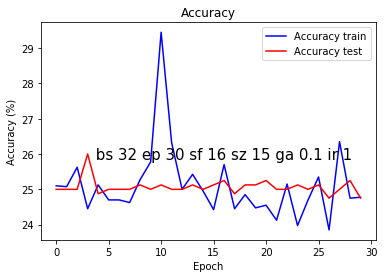

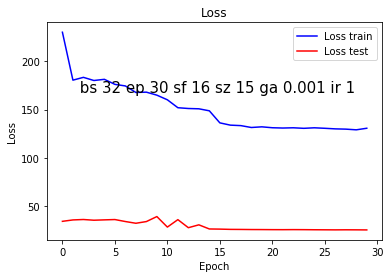

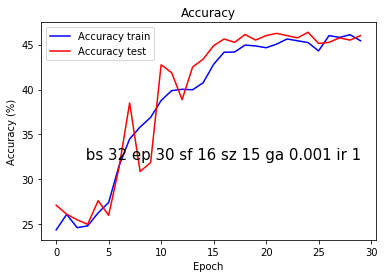

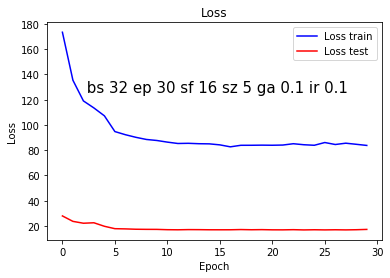

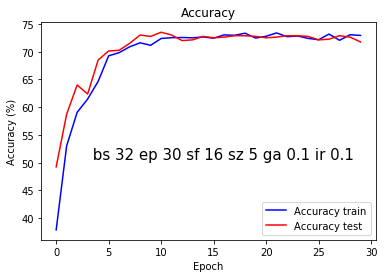

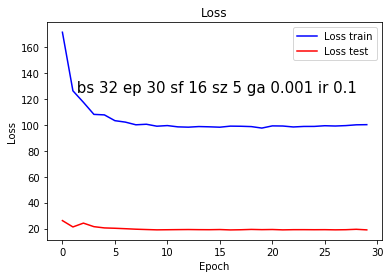

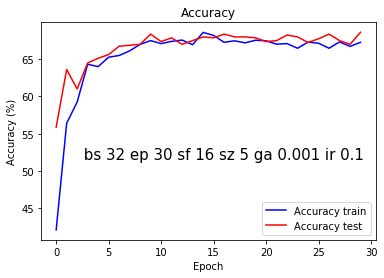

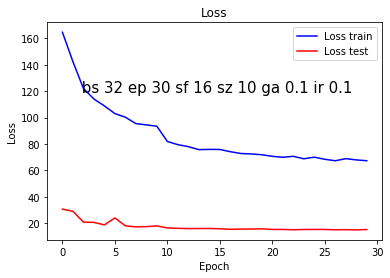

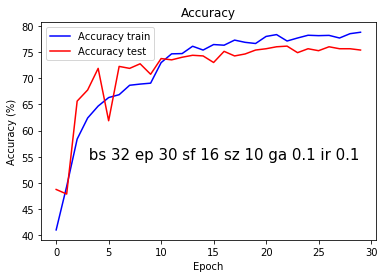

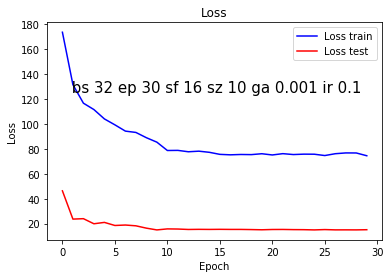

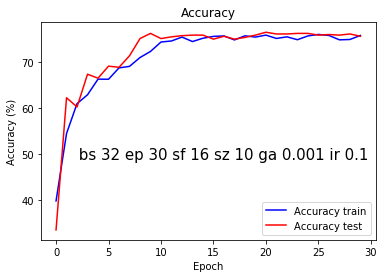

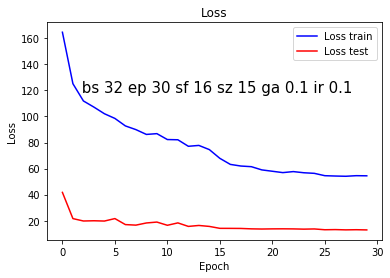

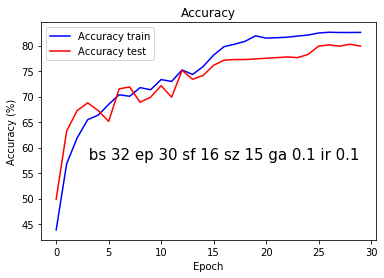

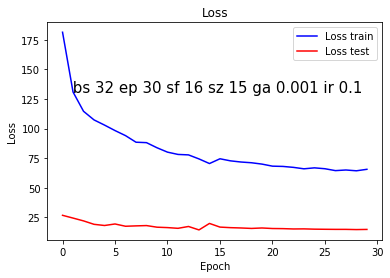

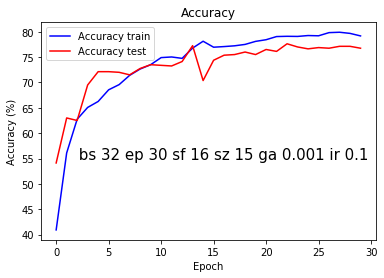

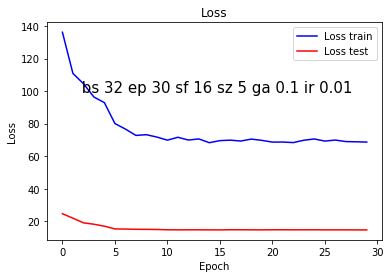

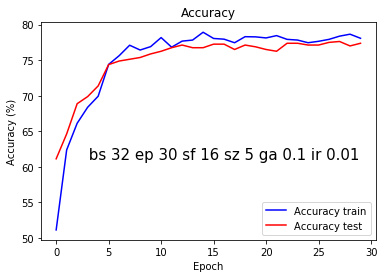

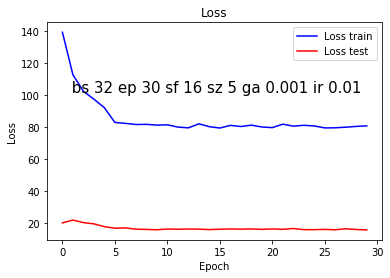

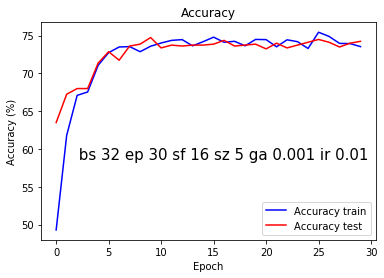

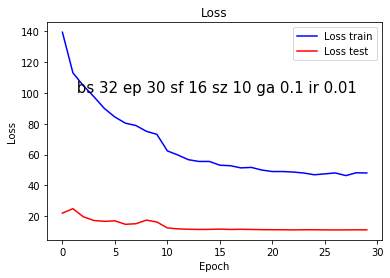

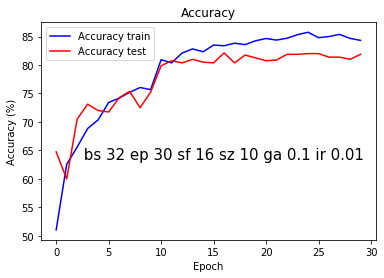

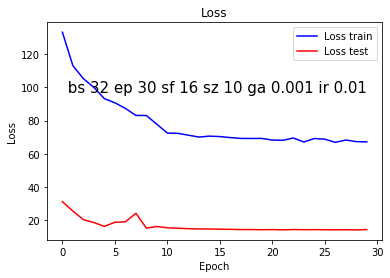

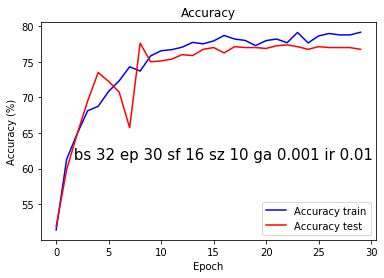

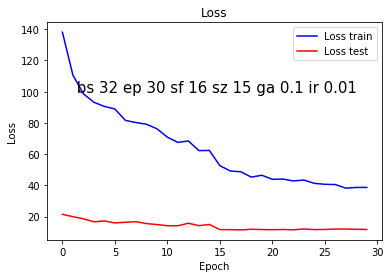

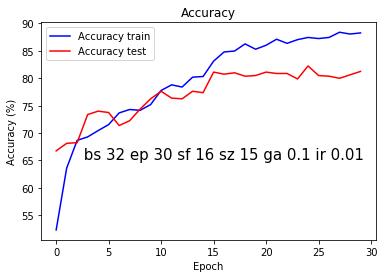

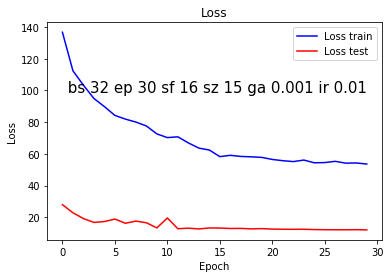

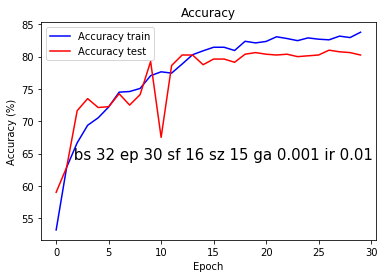

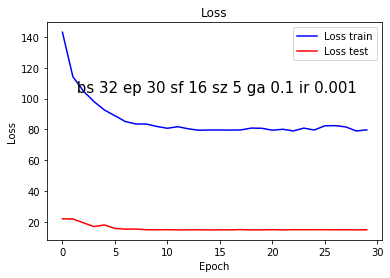

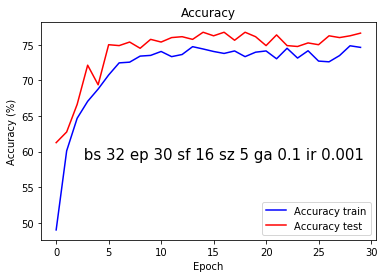

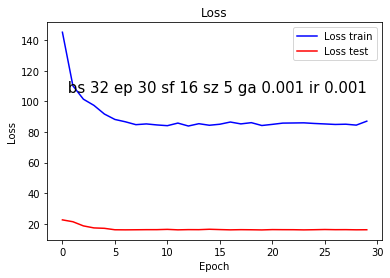

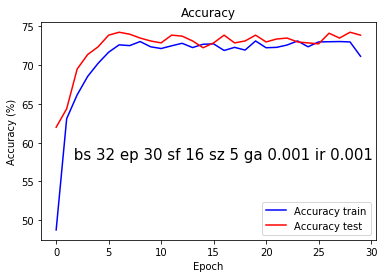

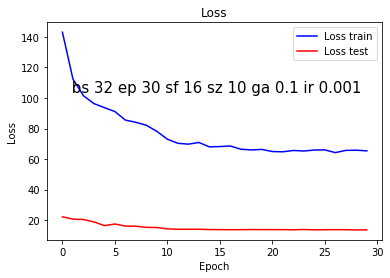

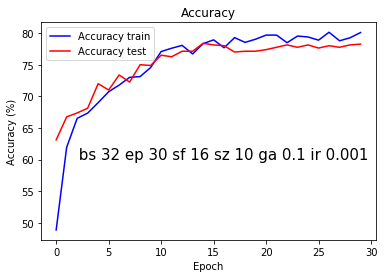

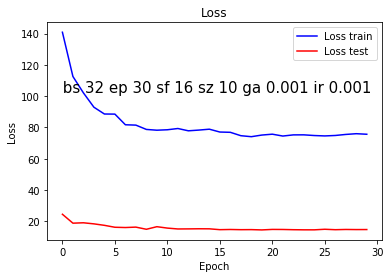

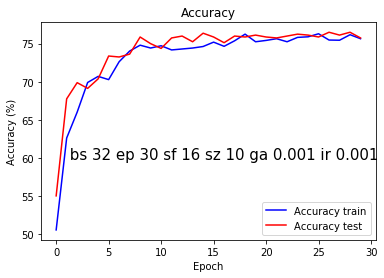

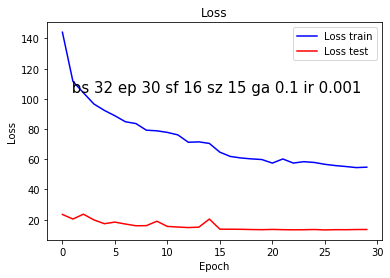

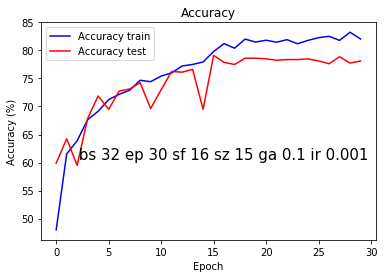

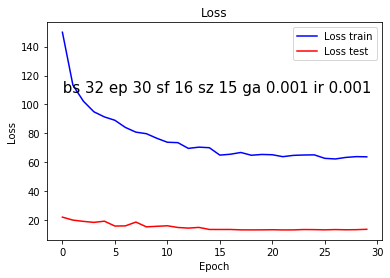

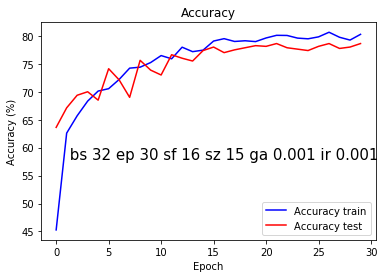

In [0]:
#Test
batch_size = 32
size_factor = 16
epoch = 30
initial_rate_list = [1 , 0.1, 0.01, 0.001]
gamma = [0.1, 0.001]
step_size_list = [5,10,15]

for i in initial_rate_list:
    for s in step_size_list:
      for g in gamma:
        main(batch_size=batch_size, size_factor=size_factor, epoch=epoch,step_size=s, initial_rate=i, gamma=g)
        print(" initial_rate :" + str(i) + " step_size : " + str(s) + " gamma :" + str(g) + " | done !" )

for i in initial_rate_list:
    for s in step_size_list:
      for g in gamma:
        plot(batch_size=batch_size, size_factor=size_factor, epoch=epoch,step_size=s, initial_rate=i, gamma=g)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
##Testing section
netTest = ResNetCustom(size_factor=8, num_classes=4)
netTest = torch.load('./save_nn.pth')
netTest = netTest.cuda()
netTest.eval()


correct = 0.0
running_loss = 0.0
total = 0.0

for _, (data, labels) in enumerate(testloader):
    #setting to cuda
    data = data.cuda()
    labels = labels.cuda()
    loss = criterion(outputs, labels)

    # compute
    outputs = netTest(data)

    # compute statistics
    total += labels.size(0)
    running_loss += loss.item()
    predicted = outputs.max(1)[1]
    correct += predicted.eq(labels).sum().item()


print('loss: %.3f' %(running_loss))
print('accuracy: %.3f' %(100*correct/total))

print('Finished Testing')



loss: 65.423
accuracy: 84.750
Finished Testing
